In [17]:
from imageio import imread, imsave
import numpy as np
import cv2
import meshplot
from imageio import imread, imsave
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import meshplot as mp
from skimage.feature import ORB
from skimage.color import rgb2gray
from skimage.feature import match_descriptors
from collections import defaultdict

In [18]:

def load(name):
    input_imgs = [None for i in range(7)]
    
    ref_img = imread('{}/ref_img.jpg'.format(name))

    print("Reference Image:")
    plt.axis('off')
    plt.imshow(ref_img)
    plt.show()
    
    print('Input Images:')
    for i in range(1,6):
        input_imgs[i] = imread('{}/{}{}.jpg'.format(name, name, i))
        plt.axis('off')
        plt.imshow(input_imgs[i])
        plt.show()
        
        
    return ref_img, input_imgs


def extract_correspondences(im1, im2, coeff):
    
    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    
    pts1 = []
    pts2 = []
    angles1 = []
    angles2 = []
    scales1 = []
    scales2 = []

    sift = cv2.SIFT_create()
    
    kp1, des1 = sift.detectAndCompute(im1,None)
    kp2, des2 = sift.detectAndCompute(im2,None)
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
    
    good_matches = []
    for m,n in matches:
        if m.distance < coeff*n.distance:
            good_matches.append([m])
            pt1 = kp1[m.queryIdx].pt
            pt2 = kp2[m.trainIdx].pt
            pts1.append((int(round(pt1[0])), int(round(pt1[1]))))
            pts2.append((int(round(pt2[0])), int(round(pt2[1]))))
            angles1.append(np.deg2rad(kp1[m.queryIdx].angle))
            angles2.append(np.deg2rad(kp2[m.trainIdx].angle))
            scales1.append(kp1[m.queryIdx].size)
            scales2.append(kp2[m.trainIdx].size)
            
    

    pts1 = np.array(pts1)
    pts2 = np.array(pts2)

    
    return pts1, pts2, good_matches, kp1, kp2, angles1, angles2, scales1, scales2

class Database(object):
    def __init__(self, ref_img):
        self.ref_img = ref_img
        self.ref_h, self.ref_w = ref_img.shape[:2]
        
    def match(self, input_img, coeff = 0.3):
        self.pts1, self.pts2, self.matches, self.kp1, self.kp2, self.angles1, self.angles2, self.scales1, self.scales2 \
            = extract_correspondences(self.ref_img, input_img, coeff)
    
    def query(self, index):
        ref_angle = self.angles1[index]
        query_angle = self.angles2[index]
        ref_scale = self.scales1[index]
        query_scale = self.scales2[index]
        ref_pt = self.pts1[index]
        query_pt = self.pts2[index]
        
        c1 = - ref_pt
        c2 = (self.ref_w, self.ref_h) - ref_pt
        
        def rotate(v, angle):
            return np.array([v[0]*np.cos(angle) - v[1]*np.sin(angle), v[0]*np.sin(angle) + v[1]*np.cos(angle)])
        

        c1_new = rotate(c1, query_angle - ref_angle)
        c2_new = rotate(c2, query_angle - ref_angle)
        
        scale_ratio = query_scale/ref_scale
        
        c1_new *= scale_ratio
        c2_new *= scale_ratio
        
        box1 = c1_new + query_pt
        box2 = c2_new + query_pt
        
        box1 = [int(x) for x in box1]
        box2 = [int(x) for x in box2]
        
        return box1, box2

def test_sift(ref_img, input_img, coeff):
    pts1, pts2, matches_for_plot, kp1, kp2, angles1, angles2, scales1, scales2 = extract_correspondences(ref_img, input_img, coeff)

    img3 = cv2.drawMatchesKnn(ref_img,kp1, input_img,
                              kp2, matches_for_plot, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.figure(figsize=(20, 10))
    plt.axis('off')
    plt.imshow(img3)
    plt.show()
    
class HoughTransform(object):
    def __init__(self, input_img, bin_size = 1):
        h,w = input_img.shape[:2]
        self.bin_size = bin_size
        self.who_voted = {}
        self.accumulator = defaultdict(int)
    
    def fit(self, top_left_pts, bottom_right_pts):
        n = len(top_left_pts)
        
        for idx in range(n):
            tli, tlj = top_left_pts[idx]
            bri, brj = bottom_right_pts[idx]
            
            tlibin = tli//self.bin_size
            tljbin = tlj//self.bin_size
            bribin = bri//self.bin_size
            brjbin = brj//self.bin_size

            
            self.accumulator[tlibin, tljbin, bribin, brjbin] += 1
           
            if (tlibin, tljbin, bribin, brjbin) not in self.who_voted:
                self.who_voted[(tlibin, tljbin, bribin, brjbin)] = [idx]
            else:
                self.who_voted[(tlibin, tljbin, bribin, brjbin)].append(idx)
        
        mx = -1e9
        for key, value in self.accumulator.items():
            if value > mx:
                mx = value 
                best_bin = key

        return self.who_voted[best_bin]

def detect(ref_db, input_img, match_coeff, bin_size, line_thickness = 5):
    ref_db.match(input_img, match_coeff)
    
    top_left_pts = []
    bottom_right_pts = []
    
    pts1 = ref_db.pts1
    pts2 = ref_db.pts2
    
    print("Number of Matches:", len(pts1))
    
    #get bounding boxes
    for i in range(len(pts1)):
        box1, box2 = ref_db.query(i)
        top_left_pts.append(box1)
        bottom_right_pts.append(box2)
        
    #Hough Transform
    hough = HoughTransform(input_img, bin_size = bin_size)
    best_keypoints = hough.fit(top_left_pts, bottom_right_pts)
    
    print('Number of keypoints after Hough Transform:', len(best_keypoints))
    
    #get homography with RANSAC
    src_pts = pts1[best_keypoints]
    dst_pts = pts2[best_keypoints]
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w,d = ref_img.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img = cv2.polylines(input_img,[np.int32(dst)],True,255,line_thickness, cv2.LINE_AA)
    
    plt.figure(figsize=(20, 10))
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    
    return dst


Reference Image:


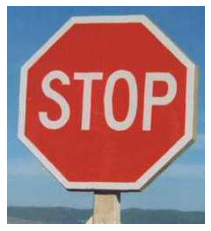

Input Images:


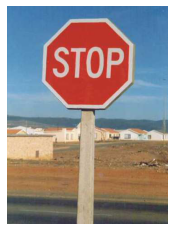

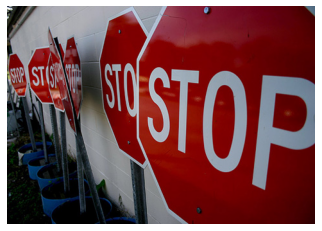

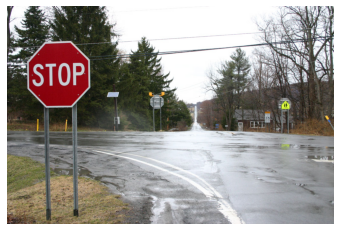

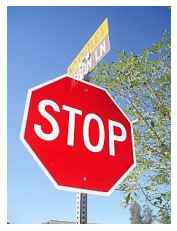

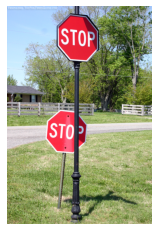

In [19]:
ref_img, input_imgs = load('stop')

Number of Matches: 76
Number of keypoints after Hough Transform: 73


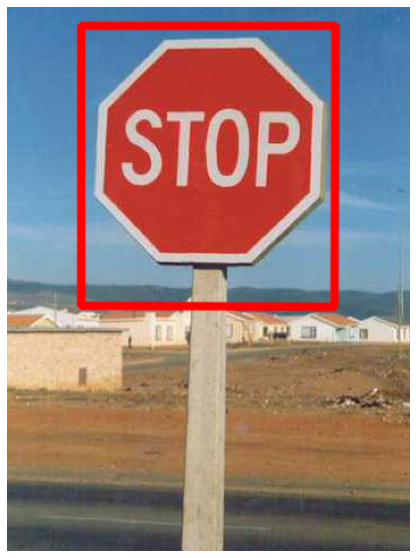

array([[[ 65.013626,  16.666279]],

       [[ 65.151215, 263.92804 ]],

       [[288.7318  , 264.19525 ]],

       [[289.05298 ,  16.566818]]], dtype=float32)

In [20]:
ref_db = Database(ref_img)
detect(ref_db, input_imgs[1], 0.5, 100)

Number of Matches: 82
Number of keypoints after Hough Transform: 11


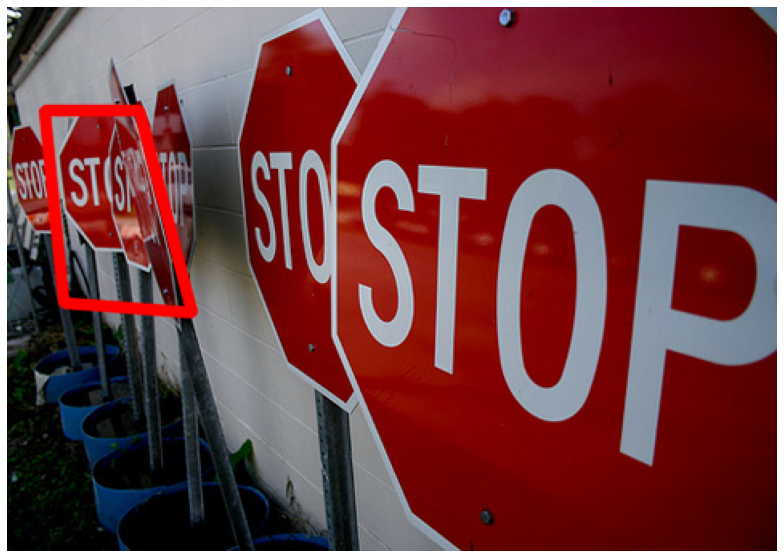

In [38]:
ref_db = Database(ref_img)
detect(ref_db, input_imgs[2], 0.9, 320)

Number of Matches: 21
Number of keypoints after Hough Transform: 18


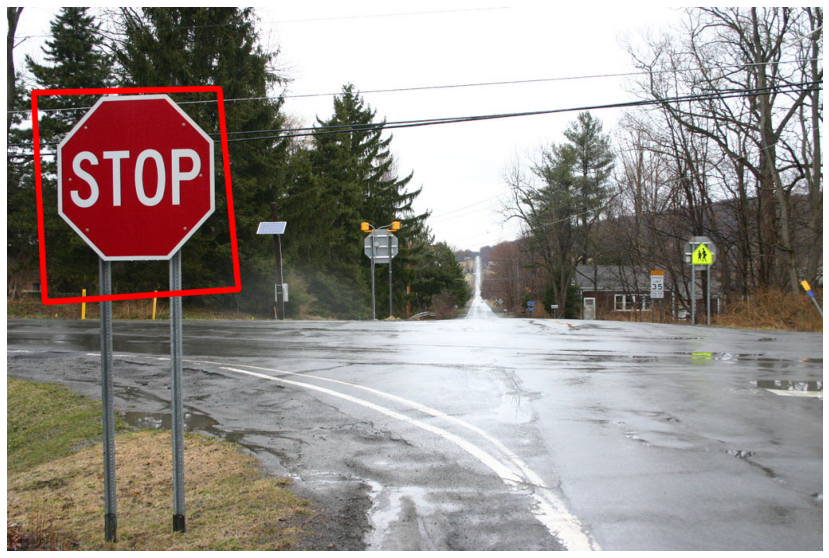

In [53]:
ref_db = Database(ref_img)
detect(ref_db, input_imgs[3], 0.55, 150)

Number of Matches: 107
Number of keypoints after Hough Transform: 49


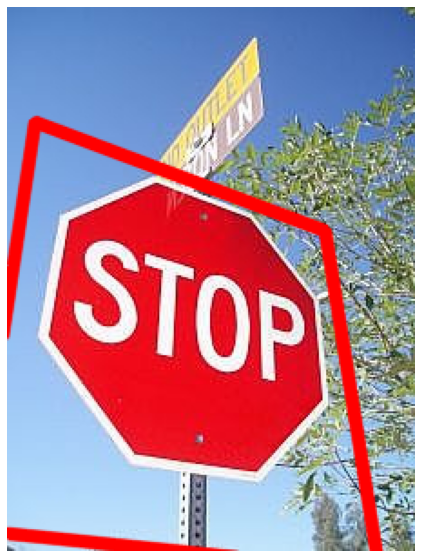

In [56]:
ref_db = Database(ref_img)
detect(ref_db, input_imgs[4], 0.9, 320)

Number of Matches: 80
Number of keypoints after Hough Transform: 27


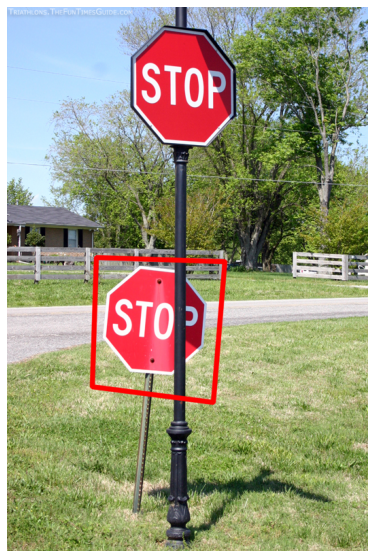

In [59]:
ref_db = Database(ref_img)
detect(ref_db, input_imgs[5], 0.9, 320)

Reference Image:


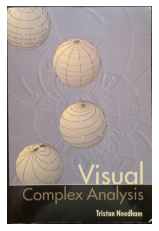

Input Images:


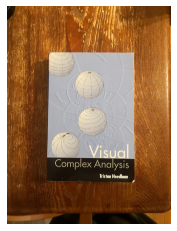

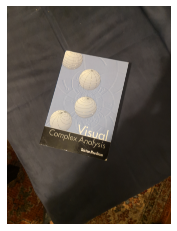

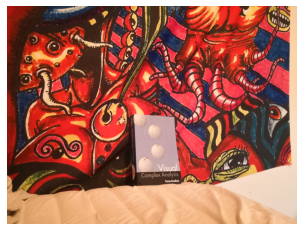

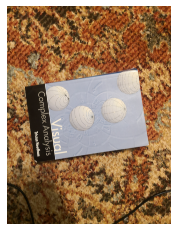

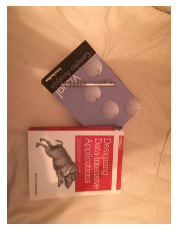

In [13]:
ref_img, input_imgs = load('book')

Number of Matches: 263
Number of keypoints after Hough Transform: 23


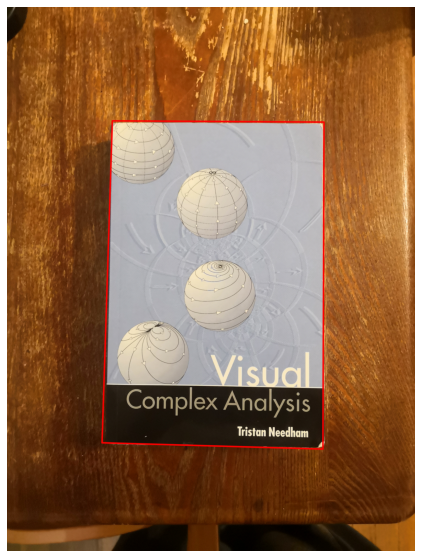

array([[[ 768.7698 ,  830.42804]],

       [[ 693.82855, 3178.4045 ]],

       [[2304.0486 , 3224.6782 ]],

       [[2312.4614 ,  839.16724]]], dtype=float32)

In [7]:
ref_db = Database(ref_img)
detect(ref_db, input_imgs[1], 0.5, 100, line_thickness = 10)

Number of Matches: 177
Number of keypoints after Hough Transform: 19


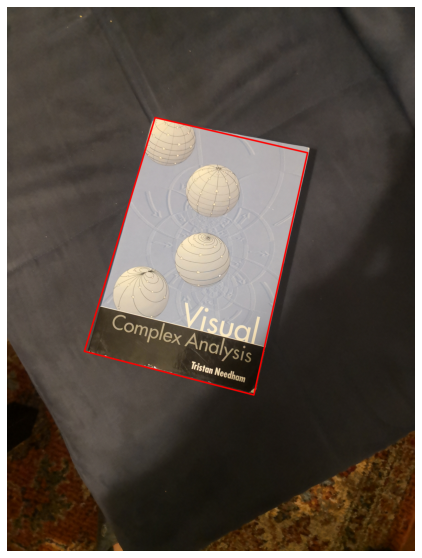

array([[[1080.3065 ,  806.8999 ]],

       [[ 564.61066, 2511.607  ]],

       [[1800.8391 , 2829.2402 ]],

       [[2192.8752 , 1063.6759 ]]], dtype=float32)

In [8]:
ref_db = Database(ref_img)
detect(ref_db, input_imgs[2], 0.5, 100, line_thickness = 10)

Number of Matches: 86
Number of keypoints after Hough Transform: 22


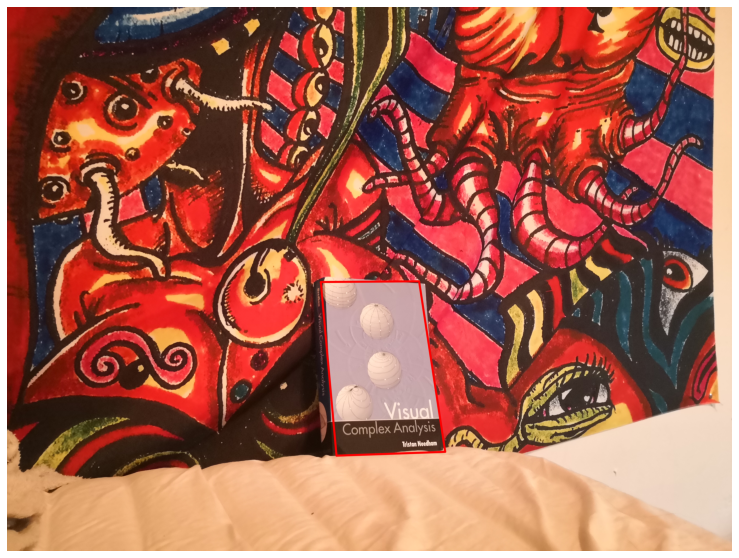

array([[[1717.2467, 1504.336 ]],

       [[1803.243 , 2454.631 ]],

       [[2398.1855, 2433.3118]],

       [[2255.5676, 1500.5   ]]], dtype=float32)

In [14]:
ref_db = Database(ref_img)
detect(ref_db, input_imgs[3], 0.6, 200, line_thickness = 10)

Number of Matches: 155
Number of keypoints after Hough Transform: 18


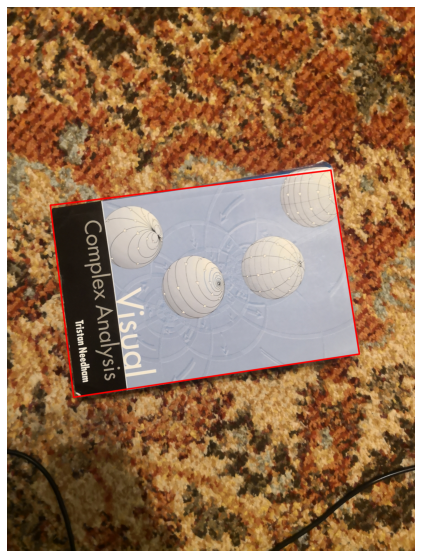

array([[[2362.529  , 1190.79   ]],

       [[ 316.55713, 1446.4857 ]],

       [[ 486.84555, 2846.9724 ]],

       [[2570.7327 , 2531.6628 ]]], dtype=float32)

In [15]:
ref_db = Database(ref_img)
detect(ref_db, input_imgs[4], 0.5, 100, line_thickness = 10)

Number of Matches: 136
Number of keypoints after Hough Transform: 22


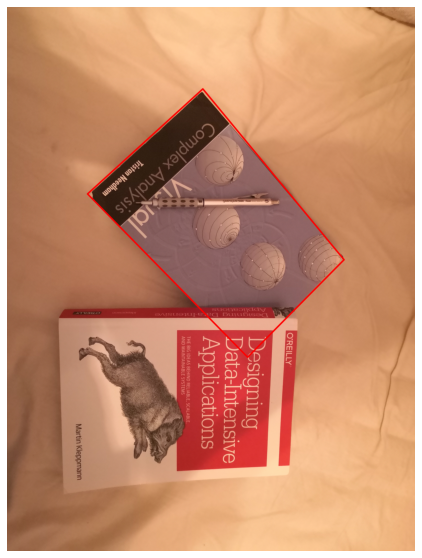

array([[[2458.1055 , 1843.7051 ]],

       [[1428.8062 ,  597.75867]],

       [[ 587.9625 , 1363.1517 ]],

       [[1755.2142 , 2554.8855 ]]], dtype=float32)

In [16]:
ref_db = Database(ref_img)
detect(ref_db, input_imgs[5], 0.5, 100, line_thickness = 10)